Large Language Models (LLMs) such as GPT3/4, Falcon, and Llama are rapidly advancing in their ability to tackle human-centric tasks, establishing themselves as essential tools in modern knowledge-based industries. Deploying these models in real-world tasks remains challenging, however:

To exhibit near-human text understanding and generation capabilities, LLMs currently require to be composed of billions of parameters (see Kaplan et al, Wei et. al). This consequently amplifies the memory demands for inference.
In many real-world tasks, LLMs need to be given extensive contextual information. This necessitates the model’s capability to manage very long input sequences during inference.

The crux of these challenges lies in augmenting the computational and memory capabilities of LLMs, especially when handling expansive input sequences.

In this guide, we will go over the effective techniques for efficient LLM deployment:

Lower Precision: Research has shown that operating at reduced numerical precision, namely 8-bit and 4-bit can achieve computational advantages without a considerable decline in model performance.

Flash Attention: Flash Attention is a variation of the attention algorithm that not only provides a more memory-efficient approach but also realizes increased efficiency due to optimized GPU memory utilization.

Architectural Innovations: Considering that LLMs are always deployed in the same way during inference, namely autoregressive text generation with a long input context, specialized model architectures have been proposed that allow for more efficient inference. The most important advancement in model architectures hereby are Alibi, Rotary embeddings, Multi-Query Attention (MQA) and Grouped-Query-Attention (GQA).

Throughout this guide, we will offer an analysis of auto-regressive generation from a tensor’s perspective. We delve into the pros and cons of adopting lower precision, provide a comprehensive exploration of the latest attention algorithms, and discuss improved LLM architectures. While doing so, we run practical examples showcasing each of the feature improvements.
1. Lower Precision

Memory requirements of LLMs can be best understood by seeing the LLM as a set of weight matrices and vectors and the text inputs as a sequence of vectors. In the following, the definition weights will be used to signify all model weight matrices and vectors.

At the time of writing this guide, LLMs consist of at least a couple billion parameters. Each parameter thereby is made of a decimal number, e.g. 4.5689 which is usually stored in either float32, bfloat16, or float16 format. This allows us to easily compute the memory requirement to load the LLM into memory:

Loading the weights of a model having X billion parameters requires roughly 4 X GB of VRAM in float32 precision*

Nowadays, models are however rarely trained in full float32 precision, but usually in bfloat16 precision or less frequently in float16 precision. Therefore the rule of thumb becomes:

Loading the weights of a model having X billion parameters requires roughly 2 X GB of VRAM in bfloat16/float16 precision*

For shorter text inputs (less than 1024 tokens), the memory requirement for inference is very much dominated by the memory requirement to load the weights. Therefore, for now, let’s assume that the memory requirement for inference is equal to the memory requirement to load the model into the GPU VRAM.

To give some examples of how much VRAM it roughly takes to load a model in bfloat16:

GPT3 requires 2 * 175 GB = 350 GB VRAM
Bloom requires 2 * 176 GB = 352 GB VRAM
Llama-2-70b requires 2 * 70 GB = 140 GB VRAM
Falcon-40b requires 2 * 40 GB = 80 GB VRAM
MPT-30b requires 2 * 30 GB = 60 GB VRAM
bigcode/starcoder requires 2 * 15.5 = 31 GB VRAM

As of writing this document, the largest GPU chip on the market is the A100 & H100 offering 80GB of VRAM. Most of the models listed before require more than 80GB just to be loaded and therefore necessarily require tensor parallelism and/or pipeline parallelism.

🤗 Transformers does not support tensor parallelism out of the box as it requires the model architecture to be written in a specific way. If you’re interested in writing models in a tensor-parallelism-friendly way, feel free to have a look at the text-generation-inference library.

Naive pipeline parallelism is supported out of the box. For this, simply load the model with device="auto" which will automatically place the different layers on the available GPUs as explained here. Note, however that while very effective, this naive pipeline parallelism does not tackle the issues of GPU idling. For this more advanced pipeline parallelism is required as explained here.

If you have access to an 8 x 80GB A100 node, you could load BLOOM as follows

In [1]:
!pip install transformers accelerate bitsandbytes optimum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.1/407.1 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("bigscience/bloom", device_map="auto", pad_token_id=0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/63.7k [00:00<?, ?B/s]

model_00001-of-00072.safetensors:   0%|          | 0.00/7.19G [00:00<?, ?B/s]

model_00002-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model_00003-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model_00004-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model_00005-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model_00006-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model_00007-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model_00008-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model_00009-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model_00010-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model_00011-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model_00012-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model_00013-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model_00014-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model_00015-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model_00016-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:983: UserWarning: Not enough free disk space to download the file. The expected file size is: 4932.88 MB. The target location /root/.cache/huggingface/hub only has 3026.13 MB free disk space.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:983: UserWarning: Not enough free disk space to download the file. The expected file size is: 4932.88 MB. The target location /root/.cache/huggingface/hub/models--bigscience--bloom/blobs only has 3026.13 MB free disk space.
  warnings.warn(


model_00017-of-00072.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

OSError: [Errno 28] No space left on device

By using device_map="auto" the attention layers would be equally distributed over all available GPUs.

In this guide, we will use bigcode/octocoder as it can be run on a single 40 GB A100 GPU device chip. Note that all memory and speed optimizations that we will apply going forward, are equally applicable to models that require model or tensor parallelism.

Since the model is loaded in bfloat16 precision, using our rule of thumb above, we would expect the memory requirement to run inference with bigcode/octocoder to be around 31 GB VRAM. Let’s give it a try.

We first load the model and tokenizer and then pass both to Transformers’ pipeline object.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch

model = AutoModelForCausalLM.from_pretrained("bigcode/octocoder", torch_dtype=torch.bfloat16, device_map="auto", pad_token_id=0)
tokenizer = AutoTokenizer.from_pretrained("bigcode/octocoder")

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

In [ ]:
prompt = "Question: Please write a function in Python that transforms bytes to Giga bytes.\n\nAnswer:"

result = pipe(prompt, max_new_tokens=60)[0]["generated_text"][len(prompt):]
result

Nice, we can now directly use the result to convert bytes into Gigabytes.

In [ ]:
def bytes_to_giga_bytes(bytes):
  return bytes / 1024 / 1024 / 1024

Let’s call torch.cuda.max_memory_allocated to measure the peak GPU memory allocation.

In [ ]:
bytes_to_giga_bytes(torch.cuda.max_memory_allocated())

Close enough to our back-of-the-envelope computation! We can see the number is not exactly correct as going from bytes to kilobytes requires a multiplication of 1024 instead of 1000. Therefore the back-of-the-envelope formula can also be understood as an “at most X GB” computation. Note that if we had tried to run the model in full float32 precision, a whopping 64 GB of VRAM would have been required.

Almost all models are trained in bfloat16 nowadays, there is no reason to run the model in full float32 precision if your GPU supports bfloat16. Float32 won’t give better inference results than the precision that was used to train the model.

If you are unsure in which format the model weights are stored on the Hub, you can always look into the checkpoint’s config under "torch_dtype", e.g. here. It is recommended to set the model to the same precision type as written in the config when loading with from_pretrained(..., torch_dtype=...) except when the original type is float32 in which case one can use both float16 or bfloat16 for inference.

Let’s define a flush(...) function to free all allocated memory so that we can accurately measure the peak allocated GPU memory.

In [ ]:
del pipe
del model

import gc
import torch

def flush():
  gc.collect()
  torch.cuda.empty_cache()
  torch.cuda.reset_peak_memory_stats()

Let’s call it now for the next experiment.

In [ ]:
flush()

In the recent version of the accelerate library, you can also use an utility method called release_memory()

In [ ]:
from accelerate.utils import release_memory
# ...

release_memory(model)

Now what if your GPU does not have 32 GB of VRAM? It has been found that model weights can be quantized to 8-bit or 4-bits without a significant loss in performance (see Dettmers et al.). Model can be quantized to even 3 or 2 bits with an acceptable loss in performance as shown in the recent GPTQ paper 🤯.

Without going into too many details, quantization schemes aim at reducing the precision of weights while trying to keep the model’s inference results as accurate as possible (a.k.a as close as possible to bfloat16). Note that quantization works especially well for text generation since all we care about is choosing the set of most likely next tokens and don’t really care about the exact values of the next token logit distribution. All that matters is that the next token logit distribution stays roughly the same so that an argmax or topk operation gives the same results.

There are various quantization techniques, which we won’t discuss in detail here, but in general, all quantization techniques work as follows:

Quantize all weights to the target precision
Load the quantized weights, and pass the input sequence of vectors in bfloat16 precision
Dynamically dequantize weights to bfloat16 to perform the computation with their input vectors in bfloat16 precision

In a nutshell, this means that inputs-weight matrix multiplications, withXX being the inputs,WW being a weight matrix andYY being the output:

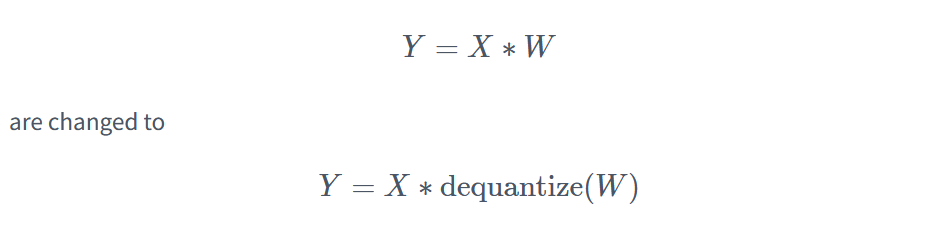

for every matrix multiplication. Dequantization and re-quantization is performed sequentially for all weight matrices as the inputs run through the network graph.

Therefore, inference time is often not reduced when using quantized weights, but rather increases. Enough theory, let’s give it a try! To quantize the weights with Transformers, you need to make sure that the bitsandbytes library is installed.

In [ ]:
!pip install bitsandbytes

We can then load models in 8-bit quantization by simply adding a load_in_8bit=True flag to from_pretrained.

In [ ]:
model = AutoModelForCausalLM.from_pretrained("bigcode/octocoder", load_in_8bit=True, pad_token_id=0)

Now, let’s run our example again and measure the memory usage.

In [ ]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

result = pipe(prompt, max_new_tokens=60)[0]["generated_text"][len(prompt):]
result

Nice, we’re getting the same result as before, so no loss in accuracy! Let’s look at how much memory was used this time.

In [ ]:
bytes_to_giga_bytes(torch.cuda.max_memory_allocated())

Significantly less! We’re down to just a bit over 15 GBs and could therefore run this model on consumer GPUs like the 4090. We’re seeing a very nice gain in memory efficiency and more or less no degradation to the model’s output. However, we can also notice a slight slow-down during inference.

We delete the models and flush the memory again.

In [ ]:
del model
del pipe

In [ ]:
flush()

Let’s see what peak GPU memory consumption 4-bit quantization gives. Quantizing the model to 4-bit can be done with the same API as before - this time by passing load_in_4bit=True instead of load_in_8bit=True.

In [ ]:
model = AutoModelForCausalLM.from_pretrained("bigcode/octocoder", load_in_4bit=True, low_cpu_mem_usage=True, pad_token_id=0)

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

result = pipe(prompt, max_new_tokens=60)[0]["generated_text"][len(prompt):]
result

We’re almost seeing the same output text as before - just the python is missing just before the code snippet. Let’s see how much memory was required.

In [ ]:
bytes_to_giga_bytes(torch.cuda.max_memory_allocated())

Just 9.5GB! That’s really not a lot for a >15 billion parameter model.

While we see very little degradation in accuracy for our model here, 4-bit quantization can in practice often lead to different results compared to 8-bit quantization or full bfloat16 inference. It is up to the user to try it out.

Also note that inference here was again a bit slower compared to 8-bit quantization which is due to the more aggressive quantization method used for 4-bit quantization leading toquantizequantize anddequantizedequantize taking longer during inference.

In [ ]:
del model
del pipe

In [ ]:
flush()

Overall, we saw that running OctoCoder in 8-bit precision reduced the required GPU VRAM from 32G GPU VRAM to only 15GB and running the model in 4-bit precision further reduces the required GPU VRAM to just a bit over 9GB.

4-bit quantization allows the model to be run on GPUs such as RTX3090, V100, and T4 which are quite accessible for most people.

For more information on quantization and to see how one can quantize models to require even less GPU VRAM memory than 4-bit, we recommend looking into the AutoGPTQ implementation.

As a conclusion, it is important to remember that model quantization trades improved memory efficiency against accuracy and in some cases inference time.

If GPU memory is not a constraint for your use case, there is often no need to look into quantization. However many GPUs simply can’t run LLMs without quantization methods and in this case, 4-bit and 8-bit quantization schemes are extremely useful tools.

For more in-detail usage information, we strongly recommend taking a look at the Transformers Quantization Docs. Next, let’s look into how we can improve computational and memory efficiency by using better algorithms and an improved model architecture.

2. Flash Attention

Today’s top-performing LLMs share more or less the same fundamental architecture that consists of feed-forward layers, activation layers, layer normalization layers, and most crucially, self-attention layers.

Self-attention layers are central to Large Language Models (LLMs) in that they enable the model to understand the contextual relationships between input tokens. However, the peak GPU memory consumption for self-attention layers grows quadratically both in compute and memory complexity with number of input tokens (also called sequence length) that we denote in the following byNN . While this is not really noticeable for shorter input sequences (of up to 1000 input tokens), it becomes a serious problem for longer input sequences (at around 16000 input tokens).

Let’s take a closer look. The formula to compute the outputOO of a self-attention layer for an inputXX of lengthNN is:

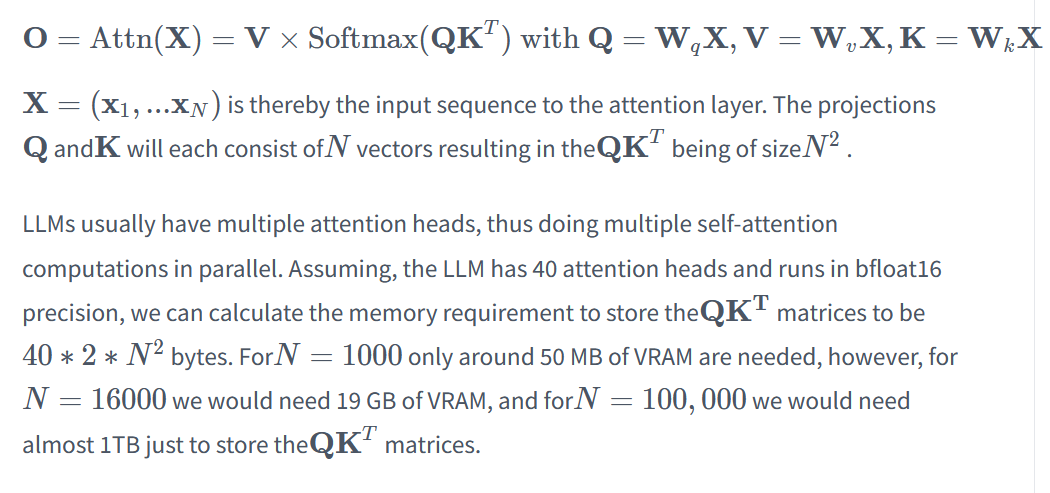

Long story short, the default self-attention algorithm quickly becomes prohibitively memory-expensive for large input contexts.

As LLMs improve in text comprehension and generation, they are applied to increasingly complex tasks. While models once handled the translation or summarization of a few sentences, they now manage entire pages, demanding the capability to process extensive input lengths.

How can we get rid of the exorbitant memory requirements for large input lengths? We need a new way to compute the self-attention mechanism that gets rid of theQKTQKT matrix. Tri Dao et al. developed exactly such a new algorithm and called it Flash Attention.

In a nutshell, Flash Attention breaks the V×Softmax(QKTV×Softmax(QKT) computation apart and instead computes smaller chunks of the output by iterating over multiple softmax computation steps:

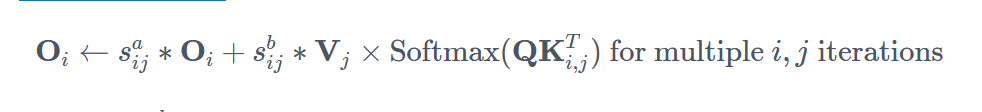

withsijasija​ andsijbsijb​ being some softmax normalization statistics that need to be recomputed for everyii andjj .

Please note that the whole Flash Attention is a bit more complex and is greatly simplified here as going in too much depth is out of scope for this guide. The reader is invited to take a look at the well-written Flash Attention paper for more details.

The main takeaway here is:

    However, Flash Attention is much faster in inference compared to default attention which comes from its ability to significantly reduce the demands on the slower, high-bandwidth memory of the GPU (VRAM), focusing instead on the faster on-chip memory (SRAM).

Essentially, Flash Attention makes sure that all intermediate write and read operations can be done using the fast on-chip SRAM memory instead of having to access the slower VRAM memory to compute the output vectorOO .

In practice, there is currently absolutely no reason to not use Flash Attention if available. The algorithm gives mathematically the same outputs, and is both faster and more memory-efficient.

Let’s look at a practical example.

Our OctoCoder model now gets a significantly longer input prompt which includes a so-called system prompt. System prompts are used to steer the LLM into a better assistant that is tailored to the users’ task. In the following, we use a system prompt that will make OctoCoder a better coding assistant.

In [ ]:
system_prompt = """Below are a series of dialogues between various people and an AI technical assistant.
The assistant tries to be helpful, polite, honest, sophisticated, emotionally aware, and humble but knowledgeable.
The assistant is happy to help with code questions and will do their best to understand exactly what is needed.
It also tries to avoid giving false or misleading information, and it caveats when it isn't entirely sure about the right answer.
That said, the assistant is practical really does its best, and doesn't let caution get too much in the way of being useful.

The Starcoder models are a series of 15.5B parameter models trained on 80+ programming languages from The Stack (v1.2) (excluding opt-out requests).
The model uses Multi Query Attention, was trained using the Fill-in-the-Middle objective, and with 8,192 tokens context window for a trillion tokens of heavily deduplicated data.

-----

Question: Write a function that takes two lists and returns a list that has alternating elements from each input list.

Answer: Sure. Here is a function that does that.

def alternating(list1, list2):
   results = []
   for i in range(len(list1)):
       results.append(list1[i])
       results.append(list2[i])
   return results

Question: Can you write some test cases for this function?

Answer: Sure, here are some tests.

assert alternating([10, 20, 30], [1, 2, 3]) == [10, 1, 20, 2, 30, 3]
assert alternating([True, False], [4, 5]) == [True, 4, False, 5]
assert alternating([], []) == []

Question: Modify the function so that it returns all input elements when the lists have uneven length. The elements from the longer list should be at the end.

Answer: Here is the modified function.

def alternating(list1, list2):
   results = []
   for i in range(min(len(list1), len(list2))):
       results.append(list1[i])
       results.append(list2[i])
   if len(list1) > len(list2):
       results.extend(list1[i+1:])
   else:
       results.extend(list2[i+1:])
   return results

-----
"""

For demonstration purposes, we duplicate the system prompt by ten so that the input length is long enough to observe Flash Attention’s memory savings. We append the original text prompt "Question: Please write a function in Python that transforms bytes to Giga bytes.\n\nAnswer: Here"

In [ ]:
long_prompt = 10 * system_prompt + prompt

We instantiate our model again in bfloat16 precision.

In [ ]:
model = AutoModelForCausalLM.from_pretrained("bigcode/octocoder", torch_dtype=torch.bfloat16, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("bigcode/octocoder")

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

Let’s now run the model just like before without Flash Attention and measure the peak GPU memory requirement and inference time.

In [ ]:
import time

start_time = time.time()
result = pipe(long_prompt, max_new_tokens=60)[0]["generated_text"][len(long_prompt):]

print(f"Generated in {time.time() - start_time} seconds.")
result

We’re getting the same output as before, however this time, the model repeats the answer multiple times until it’s 60 tokens cut-off. This is not surprising as we’ve repeated the system prompt ten times for demonstration purposes and thus cued the model to repeat itself.

Note that the system prompt should not be repeated ten times in real-world applications - one time is enough!

Let’s measure the peak GPU memory requirement.

In [ ]:
bytes_to_giga_bytes(torch.cuda.max_memory_allocated())

As we can see the peak GPU memory requirement is now significantly higher than in the beginning, which is largely due to the longer input sequence. Also the generation takes a little over a minute now.

We call flush() to free GPU memory for our next experiment.

In [ ]:
flush()

For comparison, let’s run the same function, but enable Flash Attention instead. To do so, we convert the model to BetterTransformer and by doing so enabling PyTorch’s SDPA self-attention which in turn is able to use Flash Attention.

In [ ]:
model.to_bettertransformer()

Now we run the exact same code snippet as before and under the hood Transformers will make use of Flash Attention.

In [ ]:
start_time = time.time()
with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False, enable_mem_efficient=False):
    result = pipe(long_prompt, max_new_tokens=60)[0]["generated_text"][len(long_prompt):]

print(f"Generated in {time.time() - start_time} seconds.")
result

We’re getting the exact same result as before, but can observe a very significant speed-up thanks to Flash Attention.

Let’s measure the memory consumption one last time.

In [ ]:
bytes_to_giga_bytes(torch.cuda.max_memory_allocated())

And we’re almost back to our original 29GB peak GPU memory from the beginning.

We can observe that we only use roughly 100MB more GPU memory when passing a very long input sequence with Flash Attention compared to passing a short input sequence as done in the beginning.

In [ ]:
flush()

For more information on how to use Flash Attention, please have a look at this doc page.

For more information on how to use Flash Attention, please have a look at this doc page.
3. Architectural Innovations

So far we have looked into improving computational and memory efficiency by:

Casting the weights to a lower precision format
Replacing the self-attention algorithm with a more memory- and compute efficient version

Let’s now look into how we can change the architecture of an LLM so that it is most effective and efficient for task that require long text inputs, e.g.:

Retrieval augmented Questions Answering,
Summarization,
Chat

Note that chat not only requires the LLM to handle long text inputs, but it also necessitates that the LLM is able to efficiently handle the back-and-forth dialogue between user and assistant (such as ChatGPT).

Once trained, the fundamental LLM architecture is difficult to change, so it is important to make considerations about the LLM’s tasks beforehand and accordingly optimize the model’s architecture. There are two important components of the model architecture that quickly become memory and/or performance bottlenecks for large input sequences.

The positional embeddings
The key-value cache

Let’s go over each component in more detail

 3.1 Improving positional embeddings of LLMs

Self-attention puts each token in relation to each other’s tokens. As an example, theSoftmax(QKT)Softmax(QKT) matrix of the text input sequence “Hello”, “I”, “love”, “you” could look as follows:

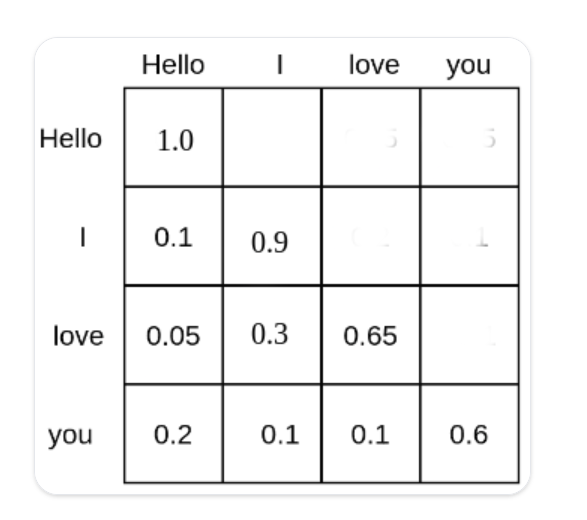

Each word token is given a probability mass at which it attends all other word tokens and, therefore is put into relation with all other word tokens. E.g. the word “love” attends to the word “Hello” with 5%, to “I” with 30%, and to itself with 65%.

A LLM based on self-attention, but without position embeddings would have great difficulties in understanding the positions of the text inputs to each other. This is because the probability score computed byQKTQKT relates each word token to each other word token inO(1)O(1) computations regardless of their relative positional distance to each other. Therefore, for the LLM without position embeddings each token appears to have the same distance to all other tokens, e.g. differentiating between “Hello I love you” and “You love I hello” would be very challenging.

For the LLM to understand sentence order, an additional cue is needed and is usually applied in the form of positional encodings (or also called positional embeddings). Positional encodings, encode the position of each token into a numerical presentation that the LLM can leverage to better understand sentence order.

The authors of the Attention Is All You Need paper introduced sinusoidal positional embeddingsP=p1,…,pNP=p1​,…,pN​ . where each vectorpipi​ is computed as a sinusoidal function of its positionii . The positional encodings are then simply added to the input sequence vectorsX^=x^1,…,x^NX^=x^1​,…,x^N​ =x1+p1,…,xN+pNx1​+p1​,…,xN​+pN​ thereby cueing the model to better learn sentence order.

Instead of using fixed position embeddings, others (such as Devlin et al.) used learned positional encodings for which the positional embeddingsPP are learned during training.

Sinusoidal and learned position embeddings used to be the predominant methods to encode sentence order into LLMs, but a couple of problems related to these positional encodings were found:

Sinusoidal and learned position embeddings are both absolute positional embeddings, i.e. encoding a unique embedding for each position id:0,…,N0,…,N . As shown by Huang et al. and Su et al., absolute positional embeddings lead to poor LLM performance for long text inputs. For long text inputs, it is advantageous if the model learns the relative positional distance input tokens have to each other instead of their absolute position.
When using learned position embeddings, the LLM has to be trained on a fixed input lengthNN, which makes it difficult to extrapolate to an input length longer than what it was trained on.

Recently, relative positional embeddings that can tackle the above mentioned problems have become more popular, most notably:

Rotary Position Embedding (RoPE)
ALiBi

Both RoPE and ALiBi argue that it’s best to cue the LLM about sentence order directly in the self-attention algorithm as it’s there that word tokens are put into relation with each other. More specifically, sentence order should be cued by modifying theQKTQKT computation.

Without going into too many details, RoPE notes that positional information can be encoded into query-key pairs, e.g.qiqi​ andxjxj​ by rotating each vector by an angleθ∗iθ∗i andθ∗jθ∗j respectively withi,ji,j describing each vectors sentence position:

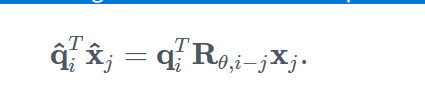

Rθ,i−j​ thereby represents a rotational matrix.θθ is not learned during training, but instead set to a pre-defined value that depends on the maximum input sequence length during training.

By doing so, the propability score betweenqiqi​ andqjqj​ is only affected ifi≠ji=j and solely depends on the relative distancei−ji−j regardless of each vector’s specific positionsii andjj .

RoPE is used in multiple of today’s most important LLMs, such as:

Falcon
Llama
PaLM

As an alternative, ALiBi proposes a much simpler relative position encoding scheme. The relative distance that input tokens have to each other is added as a negative integer scaled by a pre-defined value m to each query-key entry of theQKTQKT matrix right before the softmax computation.

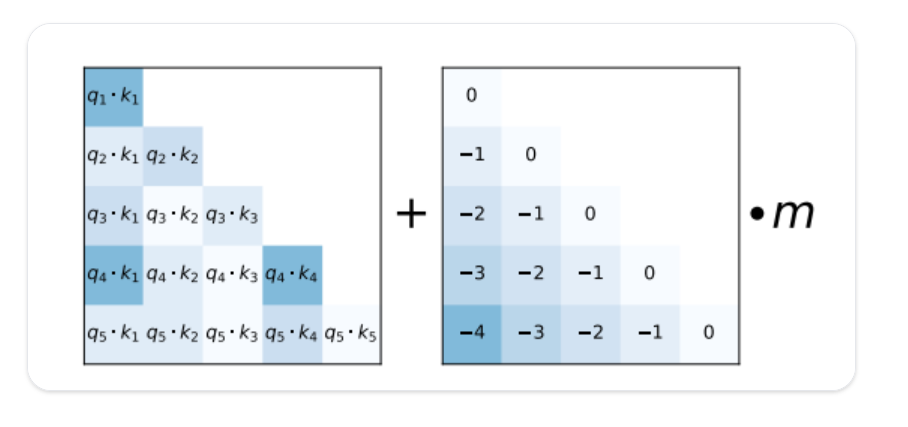

As shown in the ALiBi paper, this simple relative positional encoding allows the model to retain a high performance even at very long text input sequences.

ALiBi is used in multiple of today’s most important LLMs, such as:

    MPT
    BLOOM

Both RoPE and ALiBi position encodings can extrapolate to input lengths not seen during training whereas it has been shown that extrapolation works much better out-of-the-box for ALiBi as compared to RoPE. For ALiBi, one simply increases the values of the lower triangular position matrix to match the length of the input sequence. For RoPE, keeping the sameθθ that was used during training leads to poor results when passing text inputs much longer than those seen during training, c.f Press et al.. However, the community has found a couple of effective tricks that adaptθθ, thereby allowing RoPE position embeddings to work well for extrapolated text input sequences (see here).

    Both RoPE and ALiBi are relative positional embeddings that are not learned during training, but instead are based on the following intuitions:

        Positional cues about the text inputs should be given directly to theQKTQKT matrix of the self-attention layer
        The LLM should be incentivized to learn a constant relative distance positional encodings have to each other
        The further text input tokens are from each other, the lower the probability of their query-value probability. Both RoPE and ALiBi lower the query-key probability of tokens far away from each other. RoPE by decreasing their vector product by increasing the angle between the query-key vectors. ALiBi by adding large negative numbers to the vector product

In conclusion, LLMs that are intended to be deployed in tasks that require handling large text inputs are better trained with relative positional embeddings, such as RoPE and ALiBi. Also note that even if an LLM with RoPE and ALiBi has been trained only on a fixed length of sayN1=2048N1​=2048 it can still be used in practice with text inputs much larger thanN1N1​, likeN2=8192>N1N2​=8192>N1​ by extrapolating the positional embeddings.
3.2 The key-value cache

Auto-regressive text generation with LLMs works by iteratively putting in an input sequence, sampling the next token, appending the next token to the input sequence, and continuing to do so until the LLM produces a token that signifies that the generation has finished.

Please have a look at Transformer’s Generate Text Tutorial to get a more visual explanation of how auto-regressive generation works.

Let’s run a quick code snippet to show how auto-regressive works in practice. We will simply take the most likely next token via torch.argmax.

In [ ]:
input_ids = tokenizer(prompt, return_tensors="pt")["input_ids"].to("cuda")

for _ in range(5):
  next_logits = model(input_ids)["logits"][:, -1:]
  next_token_id = torch.argmax(next_logits,dim=-1)

  input_ids = torch.cat([input_ids, next_token_id], dim=-1)
  print("shape of input_ids", input_ids.shape)

generated_text = tokenizer.batch_decode(input_ids[:, -5:])
generated_text

As we can see every time we increase the text input tokens by the just sampled token.

With very few exceptions, LLMs are trained using the causal language modeling objective and therefore mask the upper triangle matrix of the attention score - this is why in the two diagrams above the attention scores are left blank (a.k.a have 0 probability). For a quick recap on causal language modeling you can refer to the Illustrated Self Attention blog.

As a consequence, tokens never depend on previous tokens, more specifically theqiqi​ vector is never put in relation with any key, values vectorskj,vjkj​,vj​ ifj>ij>i . Insteadqiqi​ only attends to previous key-value vectorskm<i,vm<i , for m∈{0,…i−1}km<i​,vm<i​ , for m∈{0,…i−1}. In order to reduce unnecessary computation, one can therefore cache each layer’s key-value vectors for all previous timesteps.

In the following, we will tell the LLM to make use of the key-value cache by retrieving and forwarding it for each forward pass. In Transformers, we can retrieve the key-value cache by passing the use_cache flag to the forward call and can then pass it with the current token.

In [ ]:
past_key_values = None # past_key_values is the key-value cache
generated_tokens = []
next_token_id = tokenizer(prompt, return_tensors="pt")["input_ids"].to("cuda")

for _ in range(5):
  next_logits, past_key_values = model(next_token_id, past_key_values=past_key_values, use_cache=True).to_tuple()
  next_logits = next_logits[:, -1:]
  next_token_id = torch.argmax(next_logits, dim=-1)

  print("shape of input_ids", next_token_id.shape)
  print("length of key-value cache", len(past_key_values[0][0]))  # past_key_values are of shape [num_layers, 0 for k, 1 for v, batch_size, length, hidden_dim]
  generated_tokens.append(next_token_id.item())

generated_text = tokenizer.batch_decode(generated_tokens)
generated_text

As one can see, when using the key-value cache the text input tokens are not increased in length, but remain a single input vector. The length of the key-value cache on the other hand is increased by one at every decoding step.

Making use of the key-value cache means that theQKTQKT is essentially reduced toqcKTqc​KT withqcqc​ being the query projection of the currently passed input token which is always just a single vector.

Using the key-value cache has two advantages:

Significant increase in computational efficiency as less computations are performed compared to computing the fullQKTQKT matrix. This leads to an increase in inference speed
The maximum required memory is not increased quadratically with the number of generated tokens, but only increases linearly.

One should always make use of the key-value cache as it leads to identical results and a significant speed-up for longer input sequences. Transformers has the key-value cache enabled by default when making use of the text pipeline or the generate method.

Note that, despite our advice to use key-value caches, your LLM output may be slightly different when you use them. This is a property of the matrix multiplication kernels themselves — you can read more about it here.

 3.2.1 Multi-round conversation

The key-value cache is especially useful for applications such as chat where multiple passes of auto-regressive decoding are required. Let’s look at an example.

User: How many people live in France?
Assistant: Roughly 75 million people live in France
User: And how many are in Germany?
Assistant: Germany has ca. 81 million inhabitants

In this chat, the LLM runs auto-regressive decoding twice:

The first time, the key-value cache is empty and the input prompt is "User: How many people live in France?" and the model auto-regressively generates the text "Roughly 75 million people live in France" while increasing the key-value cache at every decoding step.
The second time the input prompt is "User: How many people live in France? \n Assistant: Roughly 75 million people live in France \n User: And how many in Germany?". Thanks to the cache, all key-value vectors for the first two sentences are already computed. Therefore the input prompt only consists of "User: And how many in Germany?". While processing the shortened input prompt, it’s computed key-value vectors are concatenated to the key-value cache of the first decoding. The second Assistant’s answer "Germany has ca. 81 million inhabitants" is then auto-regressively generated with the key-value cache consisting of encoded key-value vectors of "User: How many people live in France? \n Assistant: Roughly 75 million people live in France \n User: And how many are in Germany?".

Two things should be noted here:

Keeping all the context is crucial for LLMs deployed in chat so that the LLM understands all the previous context of the conversation. E.g. for the example above the LLM needs to understand that the user refers to the population when asking "And how many are in Germany".
The key-value cache is extremely useful for chat as it allows us to continuously grow the encoded chat history instead of having to re-encode the chat history again from scratch (as e.g. would be the case when using an encoder-decoder architecture).

In transformers, a generate call will return past_key_values when return_dict_in_generate=True is passed, in addition to the default use_cache=True. Note that it is not yet available through the pipeline interface.

In [ ]:
# Generation as usual
prompt = system_prompt + "Question: Please write a function in Python that transforms bytes to Giga bytes.\n\nAnswer: Here"
model_inputs = tokenizer(prompt, return_tensors='pt')
generation_output = model.generate(**model_inputs, max_new_tokens=60, return_dict_in_generate=True)
decoded_output = tokenizer.batch_decode(generation_output.sequences)[0]

# Piping the returned `past_key_values` to speed up the next conversation round
prompt = decoded_output + "\nQuestion: How can I modify the function above to return Mega bytes instead?\n\nAnswer: Here"
model_inputs = tokenizer(prompt, return_tensors='pt')
generation_output = model.generate(
  **model_inputs,
  past_key_values=generation_output.past_key_values,
  max_new_tokens=60,
  return_dict_in_generate=True
)
tokenizer.batch_decode(generation_output.sequences)[0][len(prompt):]

Great, no additional time is spent recomputing the same key and values for the attention layer! There is however one catch. While the required peak memory for theQKTQKT matrix is significantly reduced, holding the key-value cache in memory can become very memory expensive for long input sequences or multi-turn chat. Remember that the key-value cache needs to store the key-value vectors for all previous input vectorsxi, for i∈{1,…,c−1}xi​, for i∈{1,…,c−1} for all self-attention layers and for all attention heads.

Let’s compute the number of float values that need to be stored in the key-value cache for the LLM bigcode/octocoder that we used before. The number of float values amounts to two times the sequence length times the number of attention heads times the attention head dimension and times the number of layers. Computing this for our LLM at a hypothetical input sequence length of 16000 gives:

Roughly 8 billion float values! Storing 8 billion float values in float16 precision requires around 15 GB of RAM which is circa half as much as the model weights themselves! Researchers have proposed two methods that allow to significantly reduce the memory cost of storing the key-value cache, which are explored in the next subsections.
3.2.2 Multi-Query-Attention (MQA)

Multi-Query-Attention was proposed in Noam Shazeer’s Fast Transformer Decoding: One Write-Head is All You Need paper. As the title says, Noam found out that instead of using n_head key-value projections weights, one can use a single head-value projection weight pair that is shared across all attention heads without that the model’s performance significantly degrades.

By using a single head-value projection weight pair, the key value vectorski,viki​,vi​ have to be identical across all attention heads which in turn means that we only need to store 1 key-value projection pair in the cache instead of n_head ones.

As most LLMs use between 20 and 100 attention heads, MQA significantly reduces the memory consumption of the key-value cache. For the LLM used in this notebook we could therefore reduce the required memory consumption from 15 GB to less than 400 MB at an input sequence length of 16000.

In addition to memory savings, MQA also leads to improved computational efficiency as explained in the following. In auto-regressive decoding, large key-value vectors need to be reloaded, concatenated with the current key-value vector pair to be then fed into theqcKTqc​KT computation at every step. For auto-regressive decoding, the required memory bandwidth for the constant reloading can become a serious time bottleneck. By reducing the size of the key-value vectors less memory needs to be accessed, thus reducing the memory bandwidth bottleneck. For more detail, please have a look at Noam’s paper.

The important part to understand here is that reducing the number of key-value attention heads to 1 only makes sense if a key-value cache is used. The peak memory consumption of the model for a single forward pass without key-value cache stays unchanged as every attention head still has a unique query vector so that each attention head still has a differentQKTQKT matrix.

MQA has seen wide adoption by the community and is now used by many of the most popular LLMs:

Falcon
PaLM
MPT
BLOOM

Also, the checkpoint used in this notebook - bigcode/octocoder - makes use of MQA.
3.2.3 Grouped-Query-Attention (GQA)

Grouped-Query-Attention, as proposed by Ainslie et al. from Google, found that using MQA can often lead to quality degradation compared to using vanilla multi-key-value head projections. The paper argues that more model performance can be kept by less drastically reducing the number of query head projection weights. Instead of using just a single key-value projection weight, n < n_head key-value projection weights should be used. By choosing n to a significantly smaller value than n_head, such as 2,4 or 8 almost all of the memory and speed gains from MQA can be kept while sacrificing less model capacity and thus arguably less performance.

Moreover, the authors of GQA found out that existing model checkpoints can be uptrained to have a GQA architecture with as little as 5% of the original pre-training compute. While 5% of the original pre-training compute can still be a massive amount, GQA uptraining allows existing checkpoints to be useful for longer input sequences.

GQA was only recently proposed which is why there is less adoption at the time of writing this notebook. The most notable application of GQA is Llama-v2.

As a conclusion, it is strongly recommended to make use of either GQA or MQA if the LLM is deployed with auto-regressive decoding and is required to handle large input sequences as is the case for example for chat.

Conclusion

The research community is constantly coming up with new, nifty ways to speed up inference time for ever-larger LLMs. As an example, one such promising research direction is speculative decoding where “easy tokens” are generated by smaller, faster language models and only “hard tokens” are generated by the LLM itself. Going into more detail is out of the scope of this notebook, but can be read upon in this nice blog post.

The reason massive LLMs such as GPT3/4, Llama-2-70b, Claude, PaLM can run so quickly in chat-interfaces such as Hugging Face Chat or ChatGPT is to a big part thanks to the above-mentioned improvements in precision, algorithms, and architecture. Going forward, accelerators such as GPUs, TPUs, etc… will only get faster and allow for more memory, but one should nevertheless always make sure to use the best available algorithms and architectures to get the most bang for your buck 🤗